In [446]:
%pip install torch_geometric
%pip install torch


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [447]:
import pandas as pd 


file_path = '/Users/salvatorebasilicata/Downloads/Uni/Bioinformatica/reduced_dataset_100k.csv'
dataset = pd.read_csv(file_path)

# 1. Selezioniamo le colonne rilevanti
paziente_diagnosi_malattia = dataset[['CODICE_FISCALE_ASSISTITO', 'ICD9_CM', 'DATA_PRESCRIZIONE', 'ANNO_NASCITA', 'SESSO', 'DISEASE_LABEL']]
print(dataset['DATA_PRESCRIZIONE'])
# Convertiamo le date in formato datetime
paziente_diagnosi_malattia['DATA_PRESCRIZIONE'] = pd.to_datetime(paziente_diagnosi_malattia['DATA_PRESCRIZIONE'])
import pandas as pd

# Supponiamo che 'dataset' sia il DataFrame originale
paziente_diagnosi_malattia = dataset[['CODICE_FISCALE_ASSISTITO', 'ICD9_CM', 'DATA_PRESCRIZIONE', 'ANNO_NASCITA', 'SESSO', 'DISEASE_LABEL']]

# 1. Converte la colonna DATA_PRESCRIZIONE in datetime
paziente_diagnosi_malattia['DATA_PRESCRIZIONE'] = pd.to_datetime(paziente_diagnosi_malattia['DATA_PRESCRIZIONE'])

# 2. Ordina il dataset in ordine crescente in base alla DATA_PRESCRIZIONE
paziente_diagnosi_malattia = paziente_diagnosi_malattia.sort_values(by='DATA_PRESCRIZIONE')

#Rimozione duplicati
#paziente_diagnosi_malattia = paziente_diagnosi_malattia.groupby(['CODICE_FISCALE_ASSISTITO', 'ICD9_CM']).first().reset_index()
# 3. Definisce le soglie temporali per lo split:
#    - Training: eventi antecedenti al 1° gennaio 2019
#    - Validation: eventi dal 1° gennaio 2019 fino al 31 dicembre 2020
#    - Test: eventi dal 1° gennaio 2021 in poi
# Modifica originale problematica:
# train_end = pd.Timestamp('2013-01-01')
# val_end = pd.Timestamp('2016-01-01')

def create_temporal_splits(df, patient_id_col='CODICE_FISCALE_ASSISTITO'):
    # Calcola ultima data per ogni paziente
    patient_last_date = df.groupby(patient_id_col)['DATA_PRESCRIZIONE'].max().reset_index()
    
    # Definisci split temporali coerenti
    train_cutoff = pd.Timestamp('2018-05-16')  # 70% timeline
    val_cutoff = pd.Timestamp('2018-05-31')     # 20% 
    
    # Assegna pazienti agli split
    patient_last_date['split'] = 'test'
    patient_last_date.loc[patient_last_date['DATA_PRESCRIZIONE'] <= train_cutoff, 'split'] = 'train'
    patient_last_date.loc[(patient_last_date['DATA_PRESCRIZIONE'] > train_cutoff) & 
                         (patient_last_date['DATA_PRESCRIZIONE'] <= val_cutoff), 'split'] = 'val'
    
    # Merge con dati originali
    df_split = pd.merge(df, patient_last_date[[patient_id_col, 'split']], on=patient_id_col)
    
    return {
        'train': df_split[df_split['split'] == 'train'].drop(columns=['split']),
        'val': df_split[df_split['split'] == 'val'].drop(columns=['split']),
        'test': df_split[df_split['split'] == 'test'].drop(columns=['split'])
    }

# Prima dello split, crea un encoder persistente
from sklearn.preprocessing import LabelEncoder

# Modifica la creazione del disease_map
disease_encoder = LabelEncoder()
disease_encoder.fit(paziente_diagnosi_malattia['ICD9_CM'])

# Salva l'encoder per inference futura
import joblib
joblib.dump(disease_encoder, 'disease_encoder.pkl')

# Utilizza l'encoder per tutti gli split
splits = create_temporal_splits(paziente_diagnosi_malattia)
for split_name in ['train', 'val', 'test']:
    splits[split_name]['ICD9_encoded'] = disease_encoder.transform(splits[split_name]['ICD9_CM'])
train_data, val_data, test_data = splits['train'], splits['val'], splits['test']
# Stampa il numero di eventi in ciascun set per verifica
print("Training set:", train_data.shape[0], "eventi")
print("Validation set:", val_data.shape[0], "eventi")
print("Test set:", test_data.shape[0], "eventi")



0        2010-02-05
1        2010-01-07
2        2010-03-22
3        2010-03-22
4        2010-04-23
            ...    
99497    2013-04-22
99498    2013-05-27
99499    2013-05-22
99500    2017-01-24
99501    2017-03-02
Name: DATA_PRESCRIZIONE, Length: 99502, dtype: object
Training set: 52944 eventi
Validation set: 33560 eventi
Test set: 12998 eventi


/var/folders/ff/jv2fl6j10rl9sxj0731yq5q80000gn/T/ipykernel_72400/3114738972.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paziente_diagnosi_malattia['DATA_PRESCRIZIONE'] = pd.to_datetime(paziente_diagnosi_malattia['DATA_PRESCRIZIONE'])
/var/folders/ff/jv2fl6j10rl9sxj0731yq5q80000gn/T/ipykernel_72400/3114738972.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paziente_diagnosi_malattia['DATA_PRESCRIZIONE'] = pd.to_datetime(paziente_diagnosi_malattia['DATA_PRESCRIZIONE'])


In [448]:

def create_inductiive_splits(df, patient_id_col='CODICE_FISCALE_ASSISTITO', train_frac=0.7, val_frac=0.2):
    # pazienti unici
    unique_patients = df[patient_id_col].unique()
    
    # Shuffle e split pazienti in train/test/eval
    train_size = int(len(unique_patients) * train_frac)
    val_size = int(len(unique_patients) * val_frac)
    
    train_patients = unique_patients[:train_size]
    val_patients = unique_patients[train_size:train_size + val_size]
    test_patients = unique_patients[train_size + val_size:]
    
    # Dai le etichette di split a ogni paziente
    patient_split = pd.DataFrame({
        patient_id_col: unique_patients,
        'split': ['train'] * len(train_patients) + ['val'] * len(val_patients) + ['test'] * len(test_patients)
    })
    
    # Merge con il dataset originale
    df_split = pd.merge(df, patient_split, on=patient_id_col)
    
    return {
        'train': df_split[df_split['split'] == 'train'].drop(columns=['split']),
        'val': df_split[df_split['split'] == 'val'].drop(columns=['split']),
        'test': df_split[df_split['split'] == 'test'].drop(columns=['split'])
    }
def create_relatiive_temporal_splits(df, patient_id_col='CODICE_FISCALE_ASSISTITO', date_col='DATA_PRESCRIZIONE'):
    input_data = []
    target_data = []
    
    for patient_id, group in df.groupby(patient_id_col):
        # Sort by date
        group = group.sort_values(by=date_col)
        
        # Split into input (first 50%) and target (remaining 50%)
        split_index = len(group) // 2
        input_data.append(group.iloc[:split_index])
        target_data.append(group.iloc[split_index:])
    
    # Concatenate all input and target data
    input_df = pd.concat(input_data)
    target_df = pd.concat(target_data)
    
    return input_df, target_df

# Load or create your dataset
# Example: paziente_diagnosi_malattia = pd.read_csv('your_dataset.csv')
paziente_diagnosi_malattia = paziente_diagnosi_malattia.sample(frac=1).reset_index(drop=True)

# Step 1: Create Inductive Learning splits
splits = create_inductiive_splits(paziente_diagnosi_malattia)

# Step 2: Create Relative Temporal Splits for each split
train_input, train_target = create_relatiive_temporal_splits(splits['train'])

In [449]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import joblib
import torch

def create_inductive_splits(df, patient_id_col='CODICE_FISCALE_ASSISTITO', train_frac=0.6, val_frac=0.2):
    # Get unique patients and shuffle them
    unique_patients = df[patient_id_col].unique()
    np.random.shuffle(unique_patients)  # Shuffle the patients
    
    # Calculate split sizes
    train_size = int(len(unique_patients) * train_frac)
    val_size = int(len(unique_patients) * val_frac)
    
    train_patients = unique_patients[:train_size]
    val_patients = unique_patients[train_size:train_size + val_size]
    test_patients = unique_patients[train_size + val_size:]
    
    # Create split labels
    patient_split = pd.DataFrame({
        patient_id_col: unique_patients,
        'split': ['train'] * train_size + ['val'] * val_size + ['test'] * len(test_patients)
    })
    
    # Merge with the original dataframe
    df_split = pd.merge(df, patient_split, on=patient_id_col)
    
    return {
        'train': df_split[df_split['split'] == 'train'].drop(columns=['split']),
        'val': df_split[df_split['split'] == 'val'].drop(columns=['split']),
        'test': df_split[df_split['split'] == 'test'].drop(columns=['split'])
    }

def create_relative_temporal_splits(df, patient_id_col='CODICE_FISCALE_ASSISTITO', date_col='DATA_PRESCRIZIONE'):
    input_sequences = []
    target_sequences = []
    patient_ids = []  # Track patient IDs for each sequence
    target_lengths = []
    
    grouped = df.groupby(patient_id_col)
    
    for patient_id, group in grouped:
        group = group.sort_values(by=date_col)
        date_groups = group.groupby(date_col)
        dates = sorted(date_groups.groups.keys())
        
        if len(dates) < 2:
            continue
        
        dates_codes = []
        for date in dates:
            codes = date_groups.get_group(date)['ICD9_CM'].tolist()
            dates_codes.append(codes)
        
        for i in range(len(dates_codes) - 1):
            input_sequence = sum(dates_codes[:i+1], [])
            target_sequence = dates_codes[i+1]
            
            input_sequences.append(input_sequence)
            target_sequences.append(target_sequence)
            patient_ids.append(patient_id)  # Append patient ID
            target_lengths.append(len(target_sequence))
    
    if target_lengths:
        avg_length = sum(target_lengths) / len(target_lengths)
        print(f"Average future window length: {avg_length:.2f}")
    else:
        print("No valid target sequences found.")
    
    return input_sequences, target_sequences, patient_ids  # Return patient IDs
def create_enhanced_temporal_splits(df, disease_encoder, patient_id_col='CODICE_FISCALE_ASSISTITO', date_col='DATA_PRESCRIZIONE'):
    """Returns input sequences, encoded future targets, patient IDs"""
    input_sequences = []
    all_future_targets = []
    patient_ids = []
    
    grouped = df.groupby(patient_id_col)
    
    for pid, group in grouped:
        group = group.sort_values(date_col)
        date_groups = group.groupby(date_col)
        dates = sorted(date_groups.groups.keys())
        
        if len(dates) < 2: continue
        
        # Collect codes per date (already encoded)
        timeline = []
        for date in dates:
            codes = date_groups.get_group(date)['ICD9_encoded'].tolist()  # Use encoded values
            timeline.append(codes)
        
        # For each time point, store input and ALL future targets
        for i in range(len(timeline)-1):
            input_sequences.append(sum(timeline[:i+1], []))  # Already encoded
            all_future_targets.append(sum(timeline[i+1:], []))  # Encoded targets
            patient_ids.append(pid)
            
    return input_sequences, all_future_targets, patient_ids

# Fit the encoder on all unique ICD9 codes in the dataset first
all_icd9_codes = paziente_diagnosi_malattia['ICD9_CM'].unique()
disease_encoder = LabelEncoder()
disease_encoder.fit(all_icd9_codes)

# After creating inductive splits
splits = create_inductive_splits(paziente_diagnosi_malattia)

# Encode each split's ICD9 codes using the pre-fitted encoder
for split_name in ['train', 'val', 'test']:
    splits[split_name]['ICD9_encoded'] = disease_encoder.transform(splits[split_name]['ICD9_CM'])

# Generate input/target sequences for each split
train_input_seqs, train_target_seqs,  train_patient_ids = create_relative_temporal_splits(splits['train'])
# After creating splits:
val_inputs, val_all_future_targets, val_patient_ids = create_enhanced_temporal_splits(splits['val'], disease_encoder=disease_encoder)
test_input_seqs, test_target_seqs,test_patient_ids = create_relative_temporal_splits(splits['test'])
print("First 5 input sequences:")
for i in range(min(5, len(train_input_seqs))):  # Handle cases where there are fewer than 5 sequences
    print(train_input_seqs[i])

print("\nFirst 5 target sequences:")
for i in range(min(5, len(train_target_seqs))):
    print(train_target_seqs[i])
# Vectorized encoding function
def vectorized_encode_sequences(sequences, encoder):
    # Apply the encoder to each code in each sequence
    encoded_sequences = []
    for seq in sequences:
        # Convert the sequence to an array and encode it
        encoded_seq = encoder.transform(seq)
        encoded_sequences.append(encoded_seq)
    return encoded_sequences

# Convert to multi-hot vectors
def create_multi_hot(target_lists, num_diseases):
    vectors = torch.zeros(len(target_lists), num_diseases, dtype=torch.float)
    for i, targets in enumerate(target_lists):
        # Convert to tensor first if needed
        unique = torch.unique(torch.tensor(targets))
        vectors[i, unique.long()] = 1  # Ensure long tensor type
    return vectors

val_targets_multi_hot = create_multi_hot(val_all_future_targets, num_diseases=len(disease_encoder.classes_))




# Encode input and target sequences using vectorized function
train_input_encoded = vectorized_encode_sequences(train_input_seqs, disease_encoder)
train_target_encoded = vectorized_encode_sequences(train_target_seqs, disease_encoder)
#val_input_encoded = vectorized_encode_sequences(val_inputs_seqs, disease_encoder)
#val_target_encoded = vectorized_encode_sequences(val_all_future_targets, disease_encoder)
test_input_encoded = vectorized_encode_sequences(test_input_seqs, disease_encoder)
test_target_encoded = vectorized_encode_sequences(test_target_seqs, disease_encoder)


from collections import defaultdict

patient_all_targets = defaultdict(set)
for pid, targets in zip(train_patient_ids, train_target_encoded):
    patient_all_targets[pid].update(targets)

# Update allowed targets with validation data too:
for pid, targets in zip(val_patient_ids, val_all_future_targets):
    patient_all_targets[pid].update(targets)



for pid, targets in zip(test_patient_ids, test_target_encoded):
    patient_all_targets[pid].update(targets)

# Precompute allowed indices for each patient
num_diseases = len(disease_encoder.classes_)
patient_allowed_indices = {}

for pid, diseases in patient_all_targets.items():
    excluded = torch.tensor(list(diseases), dtype=torch.long)
    allowed_mask = torch.ones(num_diseases, dtype=torch.bool)
    allowed_mask[excluded] = False
    allowed_indices = allowed_mask.nonzero().squeeze()
    patient_allowed_indices[pid] = allowed_indices


# Convert to tensors efficiently
def sequences_to_tensors(sequences):
    return [torch.tensor(seq, dtype=torch.long) for seq in sequences]

patient_inputs_train = sequences_to_tensors(train_input_encoded)
patient_targets_train = sequences_to_tensors(train_target_encoded)
#patient_inputs_val = sequences_to_tensors(val_input_encoded)
#patient_targets_val = sequences_to_tensors(val_target_encoded)
patient_inputs_test = sequences_to_tensors(test_input_encoded)
patient_targets_test = sequences_to_tensors(test_target_encoded)


Average future window length: 2.36
Average future window length: 2.38
First 5 input sequences:
['414.9', '233']
['414.9', '233', '414.9', '414.9', '414.9']
['414.9', '233', '414.9', '414.9', '414.9', '414.9', '535.11', '414.9']
['414.9', '233', '414.9', '414.9', '414.9', '414.9', '535.11', '414.9', '414.9', '459.9', '459.9']
['414.9', '233', '414.9', '414.9', '414.9', '414.9', '535.11', '414.9', '414.9', '459.9', '459.9', '535.11']

First 5 target sequences:
['414.9', '414.9', '414.9']
['414.9', '535.11', '414.9']
['414.9', '459.9', '459.9']
['535.11']
['307.4']


MODELLO

In [450]:
import torch.nn as nn
from torch_geometric.nn import GATv2Conv
import torch.nn.functional as F





class ComorbidityPredictor(nn.Module):
    def __init__(self, num_diseases, emb_dim, num_gat_layers=2, dropout=0.2):
        super().__init__()
        # Embedding malattie globali
        self.disease_emb = nn.Embedding(num_diseases, emb_dim)
        
        # GNN per il grafo comorbidità
        self.gnn_layers = nn.ModuleList()
        for _ in range(num_gat_layers):
            self.gnn_layers.append(GATv2Conv(emb_dim, emb_dim, edge_dim=1))
        self.dropout = nn.Dropout(dropout)
        
        # encoder temporale per lo storico del paziente
        self.rnn = nn.GRU(emb_dim, emb_dim, batch_first=True)
        
        # testa di predizione
        self.classifier = nn.Linear(emb_dim, num_diseases)

    
    def forward(self, patient_sequences, global_graph):
        #Patient_sequences è la prima metà, global graph è la comorbidità di tutte le prime metà dello storico dei paazienti
        # Step 1: aggiorna i disease embedding con il global graph
        x = self.disease_emb.weight
        for gnn_layer in self.gnn_layers:
            x = F.relu(gnn_layer(x, global_graph.edge_index,edge_attr=global_graph.edge_attr))
            x = self.dropout(x)
        global_embs = x
        
        # Step 2: codifica lo storico del paziente
        seq_embs = global_embs[patient_sequences]  # lookup per gli embedding delle malattie
        outputs, h_n = self.rnn(seq_embs)  # h_n: [1, batch_size, emb_dim]
       
        # Step 3: predici le malattie future
        logits = self.classifier(h_n.squeeze(0))
        return logits

In [451]:
import torch
from torch_geometric.data import Data
from collections import defaultdict
import numpy as np
import torch.optim as optim



def build_graph(train_input, icd9_encoded_col='ICD9_encoded'):
    """
    Builds a comorbidity graph with Jaccard Index as edge weights.
    
    Args:
        train_input (pd.DataFrame): Training input data with encoded ICD9 codes.
        icd9_encoded_col (str): Column name for encoded ICD9 codes.
    
    Returns:
        torch_geometric.data.Data: Graph with edges weighted by Jaccard Index.
    """
    co_occurrence_counts = defaultdict(int)
    disease_counts = defaultdict(int)
    
    # Process each patient's unique diseases
    for _, group in train_input.groupby('CODICE_FISCALE_ASSISTITO'):
        diseases = list(set(group[icd9_encoded_col].tolist()))  # Deduplicate
        
        # Count individual disease occurrences
        for d in diseases:
            disease_counts[d] += 1
            
        # Generate co-occurrence pairs
        for i in range(len(diseases)):
            for j in range(i + 1, len(diseases)):
                pair = tuple(sorted((diseases[i], diseases[j])))
                co_occurrence_counts[pair] += 1
    
    # Build edges with Jaccard Index weights
    edge_index = []
    edge_weights = []
    
    for (src, dst), count in co_occurrence_counts.items():
        edge_index.append([src, dst])
        n_i = disease_counts[src]
        n_j = disease_counts[dst]
        jaccard = count / (n_i + n_j - count)  # Jaccard Index
        edge_weights.append(jaccard)
    
    # Convert to tensors
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_weights = torch.tensor(edge_weights, dtype=torch.float)
    
    num_nodes = train_input[icd9_encoded_col].nunique()
    return Data(edge_index=edge_index, edge_attr=edge_weights, num_nodes=num_nodes)
def build_neighbor_dict(graph):
    """
    Builds a dictionary mapping each disease to its cooccurring neighbors and their count.

    Args:
        graph (torch_geometric.data.Data): Comorbidity graph.
    
    Returns:

        dict: {disease: [(neighbor, cooccurrence count), ...]} sorted by descending count.
    """
    neighbor_dict = defaultdict(list)
    edge_index = graph.edge_index.t().tolist()  # Shape [num_edges, 2]
    edge_weights = graph.edge_attr.tolist()
    
    for (u, v), w in zip(edge_index, edge_weights):
        neighbor_dict[u].append((v, w))
        neighbor_dict[v].append((u, w))
    
    # Sort neighbors by co-occurrence count (descending)
    for disease in neighbor_dict:
        neighbor_dict[disease].sort(key=lambda x: -x[1])
    
    return neighbor_dict

In [452]:

def bpr_loss(pos_scores, neg_scores):  # Add a margin parameter
    loss = -torch.log(torch.sigmoid(pos_scores - neg_scores)).mean() # Subtract margin
    return loss

import torch.nn as nn

def evaluate_loss(patient_inputs_val, patient_targets_val, model, global_graph, 
                  num_diseases=len(paziente_diagnosi_malattia['ICD9_CM'].unique()), batch_size=32):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        indices = list(range(len(patient_inputs_val)))
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            
            # Get and pad input sequences
            batch_inputs = [patient_inputs_val[idx] for idx in batch_indices]
            batch_inputs_padded = nn.utils.rnn.pad_sequence(
                [torch.tensor(seq) for seq in batch_inputs], 
                batch_first=True, 
                padding_value=0
            )
            
            # Forward pass
            logits = model(batch_inputs_padded, global_graph)
            
            # Create multi-hot targets (for cumulative evaluation)
            batch_target_vectors = torch.zeros(len(batch_indices), num_diseases, dtype=torch.float)
            for b, idx in enumerate(batch_indices):
                target_seq = patient_targets_val[idx]
                unique_diseases = torch.unique(torch.tensor(target_seq, dtype=torch.long))

                batch_target_vectors[b, unique_diseases] = 1
            
            # Retrieve the corresponding patient IDs for this batch
            batch_patient_ids = [val_patient_ids[idx] for idx in batch_indices]
            
            # Use batch_patient_ids to get allowed indices (or for any other patient-specific logic)
            batch_allowed_indices = [patient_allowed_indices[pid] for pid in batch_patient_ids]
            
            pos_scores, neg_scores = sample_pos_neg_pairs(
                logits, batch_target_vectors, num_diseases, neighbor_dict,
                use_hard=False,  # Evaluation: no hard negatives
                batch_allowed_indices=batch_allowed_indices
            )
            
            loss = bpr_loss(pos_scores, neg_scores)
            total_loss += loss.item()
    
    avg_loss = total_loss / (len(indices) / batch_size)
    return avg_loss


global_graph = build_graph(splits['train'])

neighbor_dict = build_neighbor_dict(global_graph)


def sample_pos_neg_pairs(logits, targets, num_diseases, neighbor_dict, use_hard, batch_allowed_indices):
    """
    Samples positive and hard negative disease pairs using comorbidity graph.
    
    Args:
        logits (torch.Tensor): Model predictions of shape [batch_size, num_diseases].
        targets (torch.Tensor): Ground truth multi-hot vectors of shape [batch_size, num_diseases].
        num_diseases (int): Total number of diseases.
        neighbor_dict (dict): Precomputed neighbor relationships from the comorbidity graph.
    
    Returns:
        pos_scores (torch.Tensor): Scores for positive samples.
        neg_scores (torch.Tensor): Scores for negative samples.
    """
    if use_hard == False:
        batch_size = logits.size(0)
        pos_scores = []
        neg_scores = []
        
        for b in range(batch_size):
            pos_diseases = torch.nonzero(targets[b]).squeeze(-1)
            allowed_indices = batch_allowed_indices[b]
            
            for pos_disease in pos_diseases:
                pos_score = logits[b, pos_disease]
                
                
                num_neg_samples = 1
                if len(allowed_indices) == 0:
                    neg_diseases = torch.randint(0, num_diseases, (num_neg_samples,))
                else:
                    rand_indices = torch.randint(0, len(allowed_indices), (num_neg_samples,))
                    neg_diseases = allowed_indices[rand_indices]
                
                neg_scores_batch = logits[b, neg_diseases]
                mean_neg_score = neg_scores_batch.mean()
                
                pos_scores.append(pos_score)
                neg_scores.append(mean_neg_score)
        return torch.stack(pos_scores), torch.stack(neg_scores)
    else:
        # Archi negativi difficili
        pass
        batch_size = logits.size(0)
        pos_scores = []
        neg_scores = []
        
        for b in range(batch_size):
            # Convert positive diseases to a list of integers for quick lookup
            pos_diseases_tensor = torch.nonzero(targets[b]).squeeze(-1)
            pos_diseases_list = pos_diseases_tensor.tolist()
            
            for pos_disease_tensor in pos_diseases_tensor:
                pos_disease = pos_disease_tensor.item()
                pos_score = logits[b, pos_disease]
                
                #ottieni i negativi difficili dal grafo di comorbidità
                candidates = neighbor_dict.get(pos_disease, [])
                # Filtra le malattie già presenti 
                valid_candidates = [(n, w) for (n, w) in candidates if n not in pos_diseases_list]
                
                if valid_candidates:
                    #estrai gli indici e i pesi
                    neg_indices, neg_weights = zip(*valid_candidates)
                    weights_tensor = torch.tensor(neg_weights, dtype=torch.float)
                    
                    #normalizza i pesi in probabilità e fai il sampling
                    probs = weights_tensor / weights_tensor.sum()
                    sampled_idx = torch.multinomial(probs, num_samples=1).item()
                    neg_disease = neg_indices[sampled_idx]
                else:
                    # Fallback a random sampling se non ci sono candidati validi
                    neg_disease = torch.randint(0, num_diseases, (1,)).item()
                    while neg_disease in pos_diseases_list:
                        neg_disease = torch.randint(0, num_diseases, (1,)).item()
                
                neg_score = logits[b, neg_disease]
                pos_scores.append(pos_score)
                neg_scores.append(neg_score)
        
        pos_scores = torch.stack(pos_scores) if pos_scores else torch.tensor([])
        neg_scores = torch.stack(neg_scores) if neg_scores else torch.tensor([])
        return pos_scores, neg_scores

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        """
        Args:
            patience (int): Number of epochs to wait before stopping if no improvement.
            delta (float): Minimum change in monitored metric to qualify as improvement.
        """
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
    
    def __call__(self, val_loss):
        score = -val_loss  # Higher score means lower loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [ ]:
import random
from torch.utils.data import DataLoader


class PatientDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, targets, num_diseases):
        self.inputs = inputs
        self.num_diseases = num_diseases
        # Precompute multi-hot target vectors
        self.targets = [self._to_multi_hot(t) for t in targets]

    def _to_multi_hot(self, target_seq):
        vec = torch.zeros(self.num_diseases, dtype=torch.float)
        unique = torch.unique(target_seq)
        vec[unique] = 1
        return vec

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

def collate_fn(batch):
    inputs, targets = zip(*batch)
    # Pad input sequences
    inputs_padded = torch.nn.utils.rnn.pad_sequence(
        inputs, batch_first=True, padding_value=0
    )
    targets = torch.stack(targets)
    return inputs_padded, targets



def train_module(model,num_epochs=10, patient_id_col='CODICE_FISCALE_ASSISTITO',icd9_encoded_col = 'ICD9_encoded',num_diseases=len(paziente_diagnosi_malattia['ICD9_CM'].unique()),batch_size=100, lr=0.001,patience=5):  # Pseudocode: Training loop
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    early_stopping = EarlyStopping(patience=patience)
    training_losses = []
    validation_losses = []
  


    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        num_batches = 0
        indices = torch.randperm(len(patient_inputs_train))
        print(len(indices))

        # Calculate 10% of the list length

        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_inputs = [patient_inputs_train[idx] for idx in batch_indices]
            batch_targets = [patient_targets_train[idx] for idx in batch_indices]
            batch_patient_ids = [train_patient_ids[idx] for idx in batch_indices]  # Retrieve patient IDs
            

            # Get allowed indices for each patient in the batch
            batch_allowed_indices = [patient_allowed_indices[pid] for pid in batch_patient_ids]
            
            # Pad input sequences
            batch_inputs = nn.utils.rnn.pad_sequence(batch_inputs, batch_first=True, padding_value=0)
            batch_size_current, seq_len = batch_inputs.size()
            
            # Create multi-hot target vectors
            batch_target_vectors = torch.zeros(batch_size_current, num_diseases, dtype=torch.float)
            for b, target_seq in enumerate(batch_targets):
                unique_diseases = torch.unique(target_seq)
                batch_target_vectors[b, unique_diseases] = 1
            
            # Forward pass and loss calculation
            use_hard = random.random() < 1/10
            logits = model(batch_inputs, global_graph)
            pos_scores, neg_scores = sample_pos_neg_pairs(
                    logits, batch_target_vectors, num_diseases, neighbor_dict, 
                    use_hard=use_hard, batch_allowed_indices=batch_allowed_indices
                )
                
            # Ensure batch_targets has shape [batch_size]
            loss = bpr_loss(pos_scores, neg_scores)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            print(loss.item())
            num_batches += 1
        model.eval()
        val_loss = evaluate_loss(val_inputs, val_targets_multi_hot, model, global_graph)
        avg_train_loss = total_loss / num_batches
        training_losses.append(avg_train_loss)
        validation_losses.append(val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_train_loss}")
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break
    return training_losses, validation_losses




In [454]:
def recall_at_k(preds, targets, k=100):
    batch_size = preds.size(0)
    _, top_k_indices = torch.topk(preds, k, dim=-1)  # Top-k predictions
    recall_scores = []
    
    total_tps = 0  # Total true positives across the batch
    total_fps = 0  # Total false positives across the batch
    total_fns = 0  # Total false negatives across the batch
    
    for b in range(batch_size):
        true_positives = torch.sum(targets[b, top_k_indices[b]]).item()
        total_positives = torch.sum(targets[b]).item()
        false_negatives = total_positives - true_positives
        false_positives = k - true_positives
        
        total_tps += true_positives
        total_fps += false_positives
        total_fns += false_negatives
        
        recall = true_positives / total_positives if total_positives > 0 else 0
        recall_scores.append(recall)
    
    print(f"Recall@{k}: True Positives: {total_tps}, False Positives: {total_fps}, False Negatives: {total_fns}")
    return sum(recall_scores) / len(recall_scores)

def precision_at_k(preds, targets, k=100):
    batch_size = preds.size(0)
    _, top_k_indices = torch.topk(preds, k, dim=-1)
    precision_scores = []
    for b in range(batch_size):
        true_positives = torch.sum(targets[b, top_k_indices[b]]).item()
        precision = true_positives / k
        precision_scores.append(precision)
    return sum(precision_scores) / len(precision_scores)

def f1_at_k(preds, targets, k=100):
    batch_size = preds.size(0)
    _, top_k_indices = torch.topk(preds, k, dim=-1)
    f1_scores = []
    for b in range(batch_size):
        tp = torch.sum(targets[b, top_k_indices[b]]).item()
        total_p = torch.sum(targets[b]).item()
        recall = tp / total_p if total_p > 0 else 0
        precision = tp / k
        if (precision + recall) == 0:
            f1 = 0.0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
        f1_scores.append(f1)
    return sum(f1_scores) / len(f1_scores)

def average_precision_at_k(preds, targets, k=100):
    batch_size = preds.size(0)
    ap_scores = []
    for b in range(batch_size):
        scores = preds[b]
        target = targets[b]
        _, top_k_indices = torch.topk(scores, k)
        relevant = target[top_k_indices].cpu().numpy()
        tp_cumulative = np.cumsum(relevant)
        precision_at_positions = tp_cumulative / (np.arange(k) + 1)
        sum_precision = np.sum(precision_at_positions * relevant)
        total_positives = torch.sum(target).item()
        ap = sum_precision / total_positives if total_positives > 0 else 0.0
        ap_scores.append(ap)
    return sum(ap_scores) / len(ap_scores)

def ndcg_at_k(preds, targets, k=100):
    batch_size = preds.size(0)
    ndcg_scores = []
    for b in range(batch_size):
        scores = preds[b]
        target = targets[b]
        _, top_k_indices = torch.topk(scores, k)
        relevance = target[top_k_indices].cpu().numpy()
        dcg = 0.0
        for i, rel in enumerate(relevance):
            if rel:
                dcg += 1.0 / np.log2(i + 2)  # Position starts at 1, so i+2
        ideal_relevance = torch.sort(target, descending=True)[0][:k].cpu().numpy()
        idcg = 0.0
        for i, rel in enumerate(ideal_relevance):
            if rel:
                idcg += 1.0 / np.log2(i + 2)
        ndcg = dcg / idcg if idcg > 0 else 0.0
        ndcg_scores.append(ndcg)
    return sum(ndcg_scores) / len(ndcg_scores)

def strict_accuracy(preds, targets, threshold=0.5):
    batch_size = preds.size(0)
    num_diseases = preds.size(1)
    
    # Apply threshold to convert predictions into binary values
    preds_binary = (preds > threshold).float()
    
    total_correct = 0  # Total number of correct predictions (TP + TN)
    
    for b in range(batch_size):
        correct_predictions = torch.sum((preds_binary[b] == targets[b]).float()).item()
        total_correct += correct_predictions
    
    accuracy = total_correct / (batch_size * num_diseases)
    print(f"Strict Accuracy: {accuracy:.4f}")
    return accuracy

def eval_module(patient_inputs_val, patient_targets_val, model, global_graph, k=3, 
                num_diseases=len(paziente_diagnosi_malattia['ICD9_CM'].unique()), batch_size=32):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        indices = list(range(len(patient_inputs_val)))
        
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            
            # Get and pad input sequences
            batch_inputs = [patient_inputs_val[idx] for idx in batch_indices]
            batch_inputs_padded = nn.utils.rnn.pad_sequence(
                [torch.tensor(seq) for seq in batch_inputs], 
                batch_first=True, 
                padding_value=0
            )
            
            # Forward pass
            logits = model(batch_inputs_padded, global_graph)  # Shape: [batch_size, num_diseases]
            
            # Create multi-hot targets
            batch_target_vectors = torch.zeros(len(batch_indices), num_diseases, dtype=torch.float)
            for b, idx in enumerate(batch_indices):
                target_seq = patient_targets_val[idx]
                unique_diseases = torch.unique(torch.tensor(target_seq))
                batch_target_vectors[b, unique_diseases] = 1
            
            all_preds.append(logits)
            all_targets.append(batch_target_vectors)
    
    all_preds = torch.cat(all_preds, dim=0)  # [total_samples, num_diseases]
    all_targets = torch.cat(all_targets, dim=0)
    
    # Compute metrics with k=2

    
    recall = recall_at_k(all_preds, all_targets, k=k)
    precision = precision_at_k(all_preds, all_targets, k=k)
    f1 = f1_at_k(all_preds, all_targets, k=k)
    ap = average_precision_at_k(all_preds, all_targets, k=k)
    ndcg = ndcg_at_k(all_preds, all_targets, k=k)
    accuracy = strict_accuracy(all_preds, all_targets)
    metrics = {
        'recall@': recall,
        'precision@2': precision,
        'f1@2': f1,
        'ndcg@2': ndcg
    }
    print(f"Accuracy@{k}: {accuracy:.4f}")
    print(f"Recall@{k}: {recall:.4f}")
    print(f"Precision@{k}: {precision:.4f}")
    print(f"F1@{k}: {f1:.4f}")
    print(f"NDCG@{k}: {ndcg:.4f}")
    
    return metrics

def cumulative_recall(predictions, targets):
    """
    Computes the cumulative recall for each patient.
    For each patient, the true illnesses are ranked by the model’s predictions.
    Then, we count how many of the true illnesses appear in the top-N predictions,
    where N is the total number of true illnesses for that patient.
    """
    # Get prediction ranks for each sample
    ranked = torch.argsort(predictions, dim=1, descending=True)  # shape: [batch_size, num_diseases]
    
    # Reorder targets based on the ranking
    gathered = torch.gather(targets, 1, ranked)  # same shape as predictions
    
    # Get the indices (row, col) where there is a true label
    nonzero = torch.nonzero(gathered)  # each row is [patient_index, rank_position]
    
    batch_recalls = []
    for i in range(predictions.size(0)):
        # Total number of true future illnesses for patient i
        total_future = int(targets[i].sum().item())
        if total_future == 0:
            continue  # Skip patients with no future illnesses
        
        # Select positions for patient i (i.e. rows in nonzero where the first column equals i)
        pos_i = nonzero[nonzero[:, 0] == i][:, 1]
        
        # Count how many true illnesses are found in the top-N predictions, where N = total_future
        hits = (pos_i < total_future).sum().item()
        batch_recalls.append(hits / total_future)
    
    # If no patients have future illnesses, return 0.0 to avoid division by zero later.
    if len(batch_recalls) == 0:
        return 0.0
    return torch.tensor(batch_recalls).mean().item()


def cumulative_precision(predictions, targets):
    """
    Computes the cumulative precision for each patient.
    For each patient, the top-N predictions (where N is the number of true illnesses)
    are compared against the true labels to compute precision.
    """
    # Get prediction ranks
    ranked = torch.argsort(predictions, dim=1, descending=True)
    
    batch_precisions = []
    for i in range(predictions.size(0)):
        total_future = int(targets[i].sum().item())
        if total_future == 0:
            continue  # Skip patients with no future illnesses
        
        # Get top-N predictions where N equals the number of true future illnesses
        top_preds = ranked[i, :total_future]
        
        # Count how many of these predictions are correct
        correct = targets[i, top_preds].sum().item()
        batch_precisions.append(correct / total_future)
    
    if len(batch_precisions) == 0:
        return 0.0
    return torch.tensor(batch_precisions).mean().item()
def simulate_random_precision(targets, num_diseases=len(paziente_diagnosi_malattia['ICD9_CM'].unique()), num_simulations=100):
    """
    Simulates the cumulative precision for random predictions.

    Args:
        targets (torch.Tensor): Batch of target vectors (multi-hot encoded).
        num_diseases (int): Number of possible diseases.
        num_simulations (int): Number of simulations to run for averaging.

    Returns:
        float: Average cumulative precision from random simulations.
    """
    avg_random_precision = 0.0


    for _ in range(num_simulations):
        # Generate random predictions between 0 and 1
        random_predictions = torch.rand(targets.size(0), num_diseases)

        avg_random_precision += cumulative_precision(random_predictions, targets)

    return avg_random_precision / num_simulations

def enhanced_eval_module(model, patient_inputs_val, targets_multi_hot, 
                        global_graph, k=10, batch_size=32):
    model.eval()
    all_preds = []
    
    with torch.no_grad():
        # Process in batches
        for i in range(0, len(patient_inputs_val), batch_size):
            batch_inputs = patient_inputs_val[i:i+batch_size]
            
            # Pad sequences
            padded_batch = nn.utils.rnn.pad_sequence(
                [torch.tensor(seq) for seq in batch_inputs],
                batch_first=True,
                padding_value=0
            )
            
            # Get predictions
            logits = model(padded_batch, global_graph)
            all_preds.append(logits)
    
    # Combine predictions and calculate metrics
    all_preds = torch.cat(all_preds, dim=0)
    
    #null_hypotesis=simulate_random_precision(targets_multi_hot)
    cr = cumulative_recall(all_preds, targets_multi_hot)
    cp = cumulative_precision(all_preds,targets_multi_hot)
    print(f"Cumulative Recall: {cr:.3f}, Cumulative Precision: {cp:.3f}")
    #print(f"Coumulative Precision Random: {null_hypotesis:.3f}")


        
    # Calculate metrics using precomputed targets
    metrics = {
        f'recall@{k}': recall_at_k(all_preds, targets_multi_hot, k),
        f'precision@{k}': precision_at_k(all_preds, targets_multi_hot, k),
        f'ndcg@{k}': ndcg_at_k(all_preds, targets_multi_hot, k),
        f'map@{k}': average_precision_at_k(all_preds, targets_multi_hot, k)
    }
    
    print(f"Cumulative Evaluation Metrics @{k}:")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")
    
    return metrics



In [464]:
modelf = ComorbidityPredictor(num_diseases=len(paziente_diagnosi_malattia['ICD9_CM'].unique()), emb_dim=128)
#modelf = torch.compile(
 #   modelf,
 #   mode='max-autotune',
 #   fullgraph=True,  # For Apple Silicon optimization
  #  dynamic=False
#)


In [465]:
from matplotlib import pyplot as plt


train_loss_history, val_loss_history =train_module(modelf)
# predictions: [num_patients, num_diseases] tensor
# targets: multi-hot [num_patients, num_diseases] tensor




24911
0.6970424056053162
0.6780812740325928
0.6648303270339966
0.6292657852172852
0.6162756085395813
0.609890878200531
0.6161750555038452
0.6155325174331665
0.5631561279296875
0.5293117761611938
0.4832388460636139
0.46731290221214294
0.4395473003387451
0.4203219413757324
0.38595637679100037
0.40305671095848083
0.34743914008140564
0.34353458881378174
0.35598158836364746
0.3071296215057373
0.3254344165325165
0.26171156764030457
0.26741838455200195
0.28033435344696045
0.2740263044834137
0.26859989762306213
0.26458802819252014
0.44706347584724426
0.27824264764785767
0.19849400222301483
0.23735953867435455
0.30203282833099365
0.2364504039287567
0.1704026609659195
0.2121313065290451
0.2424967885017395
0.23846417665481567
0.38622045516967773
0.17764118313789368
0.2367008775472641
0.1671903133392334
0.18841220438480377
0.17413200438022614
0.2065419852733612
0.20057129859924316
0.2154971808195114
0.20360369980335236
0.1749347746372223
0.1753130853176117
0.22640183568000793
0.41862791776657104
0

/var/folders/ff/jv2fl6j10rl9sxj0731yq5q80000gn/T/ipykernel_72400/27523296.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unique_diseases = torch.unique(torch.tensor(target_seq, dtype=torch.long))


Epoch 1/10, Loss: 0.2210041883289814
24911
0.14458052814006805
0.1426287293434143
0.20100383460521698
0.1974758803844452
0.09235207736492157
0.1792077273130417
0.14120222628116608
0.446838915348053
0.1735011637210846
0.13180850446224213
0.446069598197937
0.16779179871082306
0.13242673873901367
0.10761907696723938
0.1248670220375061
0.1334124356508255
0.14388273656368256
0.17621298134326935
0.10325503349304199
0.15064334869384766
0.46825096011161804
0.1672167330980301
0.1977052241563797
0.1820283830165863
0.1592496782541275
0.18507534265518188
0.12048382312059402
0.12053834646940231
0.178767591714859
0.1891602873802185
0.1721513569355011
0.1877002716064453
0.16304275393486023
0.20052967965602875
0.38239628076553345
0.13146670162677765
0.1303347647190094
0.13523386418819427
0.1540929675102234
0.4807035028934479
0.13691987097263336
0.2863123118877411
0.3374609053134918
0.20331887900829315
0.18183718621730804
0.14001454412937164
0.11612675338983536
0.1293819546699524
0.22123201191425323
0.

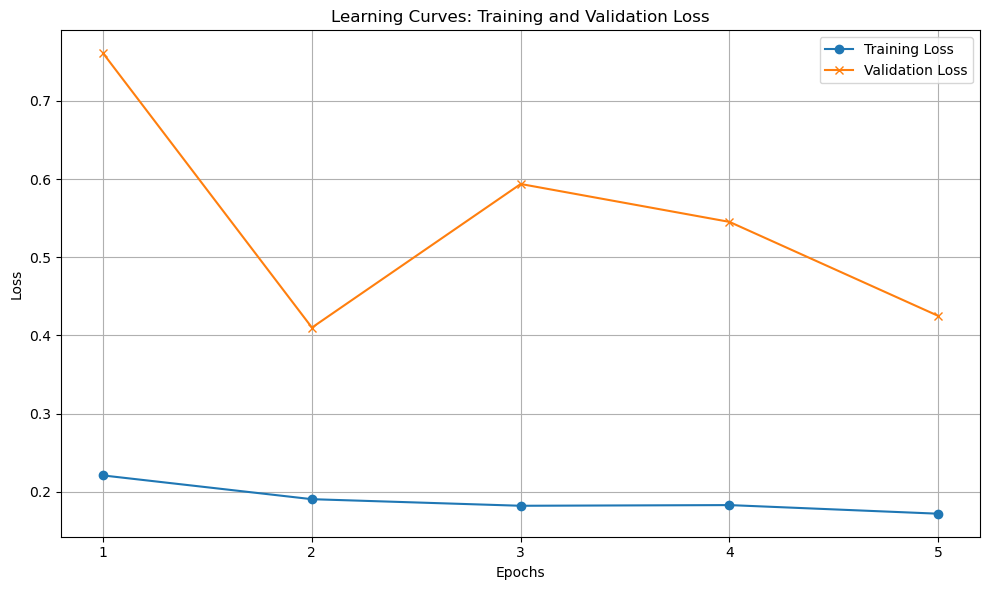

In [467]:
epochs = range(1, 5 + 1) # Epoch numbers for x-axis

plt.figure(figsize=(10, 6)) # Optional: Adjust figure size

plt.plot(epochs, train_loss_history, label='Training Loss', marker='o') # Plot training loss
plt.plot(epochs, val_loss_history, label='Validation Loss', marker='x')   # Plot validation loss

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves: Training and Validation Loss')
plt.legend() # Show legend to distinguish lines
plt.grid(True) # Optional: Add grid lines
plt.xticks(epochs) # Ensure x-axis ticks are at each epoch
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show() # Display the plot

In [468]:
#eval_module(patient_inputs_val,patient_targets_val, modelf,global_graph)# After training:
val_metrics = enhanced_eval_module(
    model=modelf,
    patient_inputs_val=val_inputs,
    targets_multi_hot=val_targets_multi_hot,
    global_graph=global_graph,
    k=4
)

Cumulative Recall: 0.285, Cumulative Precision: 0.285
Recall@4: True Positives: 16247.0, False Positives: 17293.0, False Negatives: 328635.0
Cumulative Evaluation Metrics @4:
recall@4: 0.0520
precision@4: 0.4844
ndcg@4: 0.5116
map@4: 0.0392
